\# Developer: Ali Hashaam (ali.hashaam@initos.com) <br>
\# 15th February 2019 <br>

\# © 2019 initOS GmbH <br>
\# License MIT <br>


\# Library for TSVM and SelfLearning taken from https://github.com/tmadl/semisup-learn <br>
\# Library for lagrangean-S3VM taken from https://github.com/fbagattini/lagrangean-s3vm <br>

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from methods.scikitTSVM import SKTSVM
from lagrangian_s3vm import *
from utils import *
from frameworks.SelfLearning import *
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

In [4]:
bugs = pd.read_csv('../datasets/sentiments_with_class_expansion.csv')
text_predictions_df = pd.read_csv('../datasets/unigram_based_majority_voting_classifier.csv')

In [5]:
merged_df = pd.merge(bugs, text_predictions_df, how='left', left_on='id', right_on='id')
senti_vector = merged_df[['id', 'neg_normalized', 'pos_normalized', 'neu_normalized', 'pred_class', 'class_x']]
values = {'neg_normalized': 0, 'pos_normalized': 0, 'neu_normalized': 0}
senti_vector = senti_vector.fillna(value=values)
senti_vector = senti_vector.rename({'class_x':'class'}, axis=1)
print senti_vector['class'].value_counts()

non-critical    2591
critical        1104
Name: class, dtype: int64


In [6]:
#print("members for classes {}".format(",".join("(%s,%s)" % tup for tup in sorted(Counter(Y).items()))))
def sentiment_based_classification_tsvm(senti_vector, classifier, label_type, neg_class, classifier_name):
    senti_vector.loc[senti_vector['class']=='critical', 'class'] = neg_class
    senti_vector.loc[senti_vector['class']=='non-critical', 'class'] = 1
    unlabelled_index = senti_vector[(senti_vector['class'].isnull())].index
    labelled_index = senti_vector[~(senti_vector['class'].isnull())].index
    X = np.array(senti_vector[['neg_normalized', 'pos_normalized', 'neu_normalized', 'pred_class']])
    Y = np.array(senti_vector['class'])
    X_U = X[unlabelled_index]
    X_l = X[labelled_index]
    Y_l = Y[labelled_index]
    stratified_shuffle_split = StratifiedShuffleSplit(n_splits=3, test_size=0.6, random_state=0)
    scores = []
    classifiers = []
    iteration = 1
    for train_index, test_index in stratified_shuffle_split.split(X_l, Y_l):
        X_train = X_l[train_index].copy()
        Y_train = Y_l[train_index].copy()
        X_test = X_l[test_index].copy()
        Y_test = Y_l[test_index].copy()
        X_l_u = np.vstack((X_train, X_U))
        Y_U = np.full((X_U.shape[0], ), -1)
        if label_type == 'int':
            Y_l_u = np.concatenate((Y_train, Y_U))
        else:
            Y_l_u = np.concatenate((Y_train, Y_U)).astype(float)
        classifier.fit(X_l_u, Y_l_u)
        score = classifier.score(X_test, Y_test.astype(float))
        scores.append(score)
        joblib.dump(classifier, 'models/meta_{}_{}.pkl'.format(classifier_name, iteration))
        joblib.dump(X_test, 'models/X_test_meta_{}_{}.pkl'.format(classifier_name, iteration))
        joblib.dump(Y_test, 'models/Y_test_meta_{}_{}.pkl'.format(classifier_name, iteration))
        iteration +=1
    print scores
    print "{} average score: {}".format(classifier_name, np.mean(scores))

In [7]:
def sentiment_based_classification_lsv3m(senti_vector, neg_class):
    senti_vector.loc[senti_vector['class']=='critical', 'class'] = neg_class
    senti_vector.loc[senti_vector['class']=='non-critical', 'class'] = 1
    unlabelled_index = senti_vector[(senti_vector['class'].isnull())].index
    labelled_index = senti_vector[~(senti_vector['class'].isnull())].index
    X = np.array(senti_vector[['neg_normalized', 'pos_normalized', 'neu_normalized', 'pred_class']])
    Y = np.array(senti_vector['class'])
    #print("members for classes {}".format(",".join("(%s,%s)" % tup for tup in sorted(Counter(Y).items()))))
    X_U = X[unlabelled_index]
    X_l = X[labelled_index]
    Y_l = Y[labelled_index]
    stratified_shuffle_split = StratifiedShuffleSplit(n_splits=3, test_size=0.6, random_state=0)
    scores = []
    iteration = 1
    classifiers = []
    for train_index, test_index in stratified_shuffle_split.split(X_l, Y_l):
        X_train = X_l[train_index].copy()
        Y_train = Y_l[train_index].copy()
        X_test = X_l[test_index].copy()
        Y_test = Y_l[test_index].copy()
        svc = get_best_estimator_by_cv(X_train, Y_train.astype(float), 5)
        classifier = lagrangian_s3vm_train(X_train,
                                              Y_train.astype(float),
                                              X_U,
                                              svc,
                                              r=0.5)
        score = classifier.score(X_test, Y_test.astype(float))
        joblib.dump(classifier, 'models/meta_lagrangean_S3VM_{}.pkl'.format(iteration))
        joblib.dump(X_test, 'models/X_test_meta_lagrangean_S3VM_{}.pkl'.format(iteration))
        joblib.dump(Y_test, 'models/Y_test_meta_lagrangean_S3VM_{}.pkl'.format(iteration))
        iteration +=1
        scores.append(score)
    print scores
    print "{} average score: {}".format('lagrangean S3VM', np.mean(scores))

In [ ]:
sentiment_based_classification_tsvm(senti_vector.copy(), SKTSVM(), 'int', 0, 'TSVM')

In [16]:
sklearn_lr = LogisticRegression(n_jobs=-1, class_weight='balanced')
sentiment_based_classification_tsvm(senti_vector.copy(), SelfLearningModel(sklearn_lr), 'float', 0, 'ST_LR')

[0.89670726206585472, 0.89986468200270631, 0.89941362201172759]
ST_LR average score: 0.89866185536


In [14]:
sentiment_based_classification_lsv3m(senti_vector.copy(), -1)

[0.8651330626973387, 0.85656292286874158, 0.87054578258908433]
lagrangean S3VM average score: 0.864080589385


In [10]:
def get_results(classifier, data_type):
    dict_features = {}
    model = joblib.load('models/meta_{}_{}.pkl'.format(classifier, 3))
    x_tst = joblib.load('models/X_test_meta_{}_{}.pkl'.format(classifier, 3))
    y_tst = joblib.load('models/Y_test_meta_{}_{}.pkl'.format(classifier, 3))
    acc = model.score(x_tst, y_tst.astype(data_type))
    y_pred = model.predict(x_tst)
    result = classification_report(y_tst.astype(data_type), y_pred.astype(data_type), output_dict=True)
    result = pd.DataFrame(result)
    print result
    arrays = [["Precision", "Precision", "Precision", "Recall", "Recall", "Recall", "F1-score", "F1-score", 
               "F1-score"], ['Critical', 'Non-Critical', 'Weighted Avg.', 'Critical', 'Non-Critical', 
                                       'Weighted Avg.', 'Critical', 'Non-Critical', 'Weighted Avg.']]
    MI = pd.MultiIndex.from_arrays(arrays, names=('Measures', 'Classes'))
    vals = [[round(result.loc['precision', '0'], 2)],
             [round(result.loc['precision', '1'], 2)],
             [round(result.loc['precision', 'weighted avg'], 2)],
             [round(result.loc['recall', '0'], 2)],
             [round(result.loc['recall', '1'], 2)],
             [round(result.loc['recall', 'weighted avg'], 2)],
             [round(result.loc['f1-score', '0'], 2)],
             [round(result.loc['f1-score', '1'], 2)],
             [round(result.loc['f1-score', 'weighted avg'], 2)]]
             #[round(dict_acc[str(features)],2)]]
    df = pd.DataFrame(vals, index=MI, columns=['vals'])  
    df = df.unstack().transpose().reset_index(level=0, drop=True)
    ax = df.plot(kind='bar', figsize=(8,6), rot=False)
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc='upper left')
    
    plt.xlabel('Evaluation Measure Meta Model {}'.format(classifier), fontsize=12)
    plt.savefig('meta_model_results_{}.pdf'.format(classifier), dpi=720)
    
    #result_df = pd.DataFrame(result)
    #result_df.transpose().to_csv('meta_{}_latex_table_report.csv'.format(classifier))
    #print result_df.transpose()
    return df, y_tst.astype(data_type), y_pred.astype(data_type)

                    0            1    macro avg    micro avg  weighted avg
f1-score     0.833333     0.931166     0.882250     0.902571      0.901953
precision    0.851735     0.922931     0.887333     0.902571      0.901672
recall       0.815710     0.939550     0.877630     0.902571      0.902571
support    662.000000  1555.000000  2217.000000  2217.000000   2217.000000


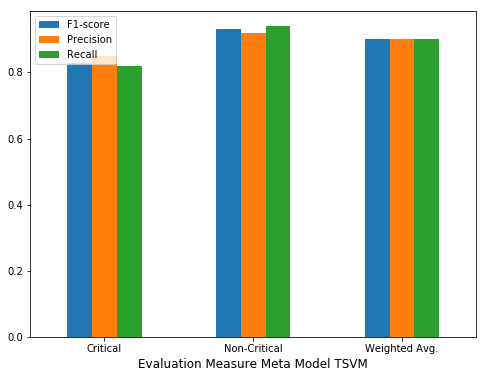

In [11]:
tsvm_results, y_test_true, y_test_pred = get_results('TSVM', int)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['Critical', 'Non-Critical'], yticklabels=['Critical', 'Non-Critical'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('Confusion_matrix(Meta Model).pdf', bbox_inches='tight')
    return ax

Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.06  0.94]]


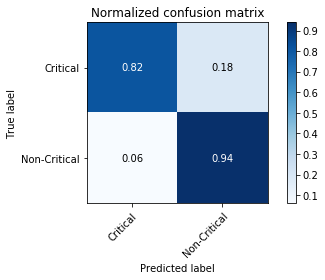

In [13]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plot_confusion_matrix(y_tst.astype(int), y_pred.astype(float), classes=[-1, 1],
#                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_true, y_test_pred, classes=[-1, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
st_results, y_test_true, y_test_pred = get_results('ST_LR', float)

In [ ]:
ls3vm_results, y_test_true, y_test_pred = get_results('lagrangean_S3VM', float)

In [6]:
df = pd.DataFrame({'QN-S3VM': {'F1-Score': round(tsvm_results.loc['f1-score', 'weighted avg'], 2),
                               'Precision': round(tsvm_results.loc['precision', 'weighted avg'], 2),
                               'Recall': round(tsvm_results.loc['recall', 'weighted avg'], 2),
                               'Accuracy': round(0.90,2)},
                   'Self-Training-LR': {'F1-Score': round(st_results.loc['f1-score', 'weighted avg'], 2),
                                        'Precision': round(st_results.loc['precision', 'weighted avg'], 2),
                                       'Recall': round(st_results.loc['recall', 'weighted avg'], 2),
                                        'Accuracy': round(0.898,2)},
                   'Lagrangean S3VM': {'F1-Score': round(ls3vm_results.loc['f1-score', 'weighted avg'], 2),
                                       'Precision': round(ls3vm_results.loc['precision', 'weighted avg'], 2),
                                       'Recall': round(ls3vm_results.loc['recall', 'weighted avg'], 2),
                                       'Accuracy': round(0.864,2)}})

In [7]:
df

,Lagrangean S3VM,QN-S3VM,Self-Training-LR
Accuracy,0.86,0.9,0.9
F1-Score,0.87,0.9,0.9
Precision,0.88,0.9,0.9
Recall,0.87,0.9,0.9


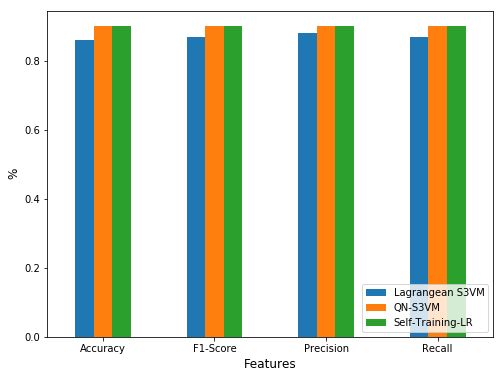

In [8]:
ax = df.plot(kind='bar', figsize=(8,6), rot=False)
plt.xlabel('Features', fontsize=12)
plt.ylabel("%", fontsize=12)
plt.legend(loc='lower right')
plt.savefig('{}_results.pdf'.format('Meta_modeling'), dpi=720)